In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np

def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:
        if image_name.split('.')[1] == 'npy':
            image_path = os.path.join(img_dir, image_name)
            image = np.load(image_path)
            images.append(image)
    return np.array(images)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            print("X shape:", X.shape)
            print("Y shape:", Y.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end   += batch_size

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 2)
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [ ]:
pip install segmentation_models_3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 8.5 MB/s eta 0:00:00


In [ ]:
from matplotlib.axis import YAxis
import os
import numpy as np
# from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random



####################################################
train_img_dir = ('/content/drive/MyDrive/data_unzip/image')
train_mask_dir = ('/content/drive/MyDrive/data_unzip/mask')

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

#img_num = random.randint(0,num_images-1)
#test_img = np.load(train_img_dir+img_list[img_num])
#test_mask = np.load(train_mask_dir+msk_list[img_num])
#test_mask = np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')
# plt.subplot(222)
# plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(223)
# plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()

#############################################################
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25


In [ ]:
import glob
import pandas as pd
columns = ['0','1' ]
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/drive/MyDrive/data_unzip/mask/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
# label_2 = df['1'].sum()
# label_3 = df['3'].sum()
total_labels = label_0 + label_1
n_classes = 2
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
# wt2 = round((total_labels/(n_classes*label_2)), 2)
# wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss

##############################################################
#Define the image generators for training and validation

#train_img_dir = ('/content/drive/MyDrive/train/image/')
#train_mask_dir = ('/content/drive/MyDrive/train/masks/')

#val_img_dir = ('/content/drive/MyDrive/val/image/')
#val_mask_dir = ('/content/drive/MyDrive/val/masks/')


0


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


1


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


2


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


3


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


4


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


5


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


6


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


7


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


8


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


9


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


10


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


11


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


12


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


13


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


14


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


15


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


16


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


17


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


18


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


19


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


20


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


21


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


22


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


23


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


24


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


25


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


26


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


27


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


28


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


29


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


30


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


31


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


32


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


33


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


34


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


35


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


36


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


37


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


38


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


39


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


40


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


41


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


42


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


43


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


44


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


45


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


46


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


47


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


48


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


49


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


50


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


51


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


52


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


53


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


54


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


55


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


56


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


57


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


58


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


59


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


60


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


61


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


62


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


63


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


64


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


65


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


66


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


67


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


68


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


69


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


70


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


71


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


72


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


73


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


74


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


75


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


76


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


77


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


78


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


79


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


80


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


81


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


82


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


83


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


84


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


85


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


86


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


87


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


88


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


89


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


90


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


91


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


92


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


93


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


94


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


95


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


96


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


97


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


98


<ipython-input-6-7f188183622d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


In [ ]:
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

img = train_img_list
mask_ = train_mask_list
print("Mask : " , mask_)

train_img_list = train_img_list[:90]
train_mask_list = train_mask_list[:90]

images = []
masks = []

for i,image_name in enumerate(train_img_list):
    if i==10:
      break
    if image_name.split('.')[1] == 'npy':
      image_path = os.path.join(train_img_dir, image_name)
      image = np.load(image_path)
      images.append(image)

    if train_mask_list[i].split('.')[1] == 'npy':
      mask_path = os.path.join(train_mask_dir, train_mask_list[i])
      mask = np.load(mask_path)
      masks.append(mask)

X_train = np.array(images)
Y_train = np.array(masks)

print(X_train)
print('******************')
print(Y_train)
print('----------------------------------')


# val_img_list=os.listdir(val_img_dir)
# val_mask_list = os.listdir(val_mask_dir)
# ##################################

# # print(train_img_list)
# # print(train_mask_list)
# ########################################################################
# batch_size = 16

# # train_img_datagen = imageLoader(train_img_dir, train_img_list,
# #                                 train_mask_dir, train_mask_list, batch_size)

# # val_img_datagen = imageLoader(val_img_dir, val_img_list,
# #                                 val_mask_dir, val_mask_list, batch_size)

# #Verify generator.... In python 3 next() is renamed as __next__()
# # img, msk = train_img_datagen.__next__()

# # img_num = random.randint(0,img.shape[0]-1)
# # test_img=img[img_num]
# # test_mask=msk[img_num]
# # test_mask=np.argmax(test_mask, axis=3)

# # n_slice=random.randint(0, test_mask.shape[2])
# # plt.figure(figsize=(12, 8))

# # plt.subplot(221)
# # plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# # plt.title('Image flair')
# # plt.subplot(222)
# # plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# # plt.title('Image t1ce')
# # plt.subplot(223)
# # plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# # plt.title('Image t2')
# # plt.subplot(224)
# # plt.imshow(test_mask[:,:,n_slice])
# # plt.title('Mask')
# # plt.show()


# ###########################################################################
# #Define loss, metrics and optimizer to be used for training
# wt0, wt1 = 0.25,0.25
# import segmentation_models_3D as sm
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

# LR = 0.0001
# optim = keras.optimizers.Adam(LR)
# #######################################################################
# #Fit the model

# steps_per_epoch = len(train_img_list)//batch_size
# val_steps_per_epoch = len(val_img_list)//batch_size


# # from  simple_3d_unet import simple_unet_model

# model = simple_unet_model(IMG_HEIGHT=128,
#                           IMG_WIDTH=128,
#                           IMG_DEPTH=128,
#                           IMG_CHANNELS=3,
#                           num_classes=2)

# model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
# print(model.summary())

# print(model.input_shape)
# print(model.output_shape)

# history=model.fit(X_train,
#           Y_train,
#           batch_size=16,
#           steps_per_epoch=steps_per_epoch,
#           epochs=4,
#           verbose=1,)
#           # validation_data=val_img_datagen,
#           # validation_steps=val_steps_per_epoch,


# model.save('/content/drive/MyDrive/test/model_new.h5')
# ##################################################################


# #plot the training and validation IoU and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
# #################################################


Mask :  ['LGG001_Augmented_Segments.npy', 'LGG010_Augmented_Segments.npy', 'LGG008_Augmented_Segments.npy', 'LGG003_Augmented_Segments.npy', 'LGG007_Augmented_Segments.npy', 'LGG002_Augmented_Segments.npy', 'LGG014_Augmented_Segments.npy', 'LGG013_Augmented_Segments.npy', 'LGG011_Augmented_Segments.npy', 'LGG015_Augmented_Segments.npy', 'LGG016_Augmented_Segments.npy', 'LGG020_Augmented_Segments.npy', 'LGG017_Augmented_Segments.npy', 'LGG019_Augmented_Segments.npy', 'LGG025_Augmented_Segments.npy', 'LGG018_Augmented_Segments.npy', 'LGG027_Augmented_Segments.npy', 'LGG026_Augmented_Segments.npy', 'LGG029_Augmented_Segments.npy', 'LGG030_Augmented_Segments.npy', 'LGG031_Augmented_Segments.npy', 'LGG032_Augmented_Segments.npy', 'LGG035_Augmented_Segments.npy', 'LGG038_Augmented_Segments.npy', 'LGG039_Augmented_Segments.npy', 'LGG041_Augmented_Segments.npy', 'LGG047_Augmented_Segments.npy', 'LGG052_Augmented_Segments.npy', 'LGG043_Augmented_Segments.npy', 'LGG042_Augmented_Segments.npy', '

In [ ]:
X_train[7].shape

(256, 256, 128, 3)

In [ ]:
batch_size=16
wt0, wt1 = 0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
#######################################################################
#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
# val_steps_per_epoch = len(val_img_list)//batch_size


model = simple_unet_model(IMG_HEIGHT=256,
                          IMG_WIDTH=256,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=2)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)






Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 256, 256, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 12  0           ['conv3d_38[0][0]']              
                                8, 16)                                                      

In [ ]:
history=model.fit(X_train,
          Y_train,
          batch_size=2,
          # steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,)
          # validation_data=val_img_datagen,
          # validation_steps=val_steps_per_epoch,


model.save('/content/drive/MyDrive/data fyp/model_new.h5')
##################################################################


Epoch 1/10
5/5 [==============================] - 5s 468ms/step - loss: 0.9342 - accuracy: 0.7349 - iou_score: 0.3728
Epoch 2/10
5/5 [==============================] - 2s 470ms/step - loss: 0.9264 - accuracy: 0.9049 - iou_score: 0.4557
Epoch 3/10
5/5 [==============================] - 2s 474ms/step - loss: 0.9118 - accuracy: 0.9422 - iou_score: 0.4750
Epoch 4/10
5/5 [==============================] - 2s 475ms/step - loss: 0.9060 - accuracy: 0.9814 - iou_score: 0.4918
Epoch 5/10
5/5 [==============================] - 2s 469ms/step - loss: 0.8998 - accuracy: 0.9858 - iou_score: 0.4932
Epoch 6/10
5/5 [==============================] - 2s 470ms/step - loss: 0.8954 - accuracy: 0.9865 - iou_score: 0.4934
Epoch 7/10
5/5 [==============================] - 2s 475ms/step - loss: 0.8879 - accuracy: 0.9868 - iou_score: 0.4935
Epoch 8/10
5/5 [==============================] - 2s 472ms/step - loss: 0.8814 - accuracy: 0.9870 - iou_score: 0.4935
Epoch 9/10
5/5 [==============================] - 2s 469

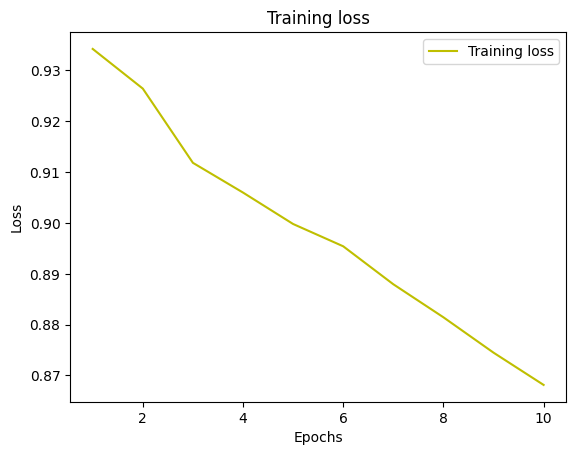

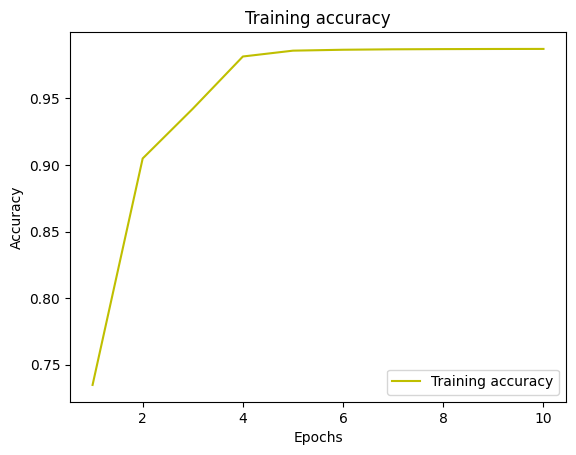

In [ ]:

#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
#plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#################################################

In [ ]:
print(train_img_list)

['LGG001_Augmented_T2.npy', 'LGG002_Augmented_T2.npy', 'LGG003_Augmented_T2.npy', 'LGG007_Augmented_T2.npy', 'LGG008_Augmented_T2.npy', 'LGG010_Augmented_T2.npy', 'LGG011_Augmented_T2.npy', 'LGG013_Augmented_T2.npy', 'LGG014_Augmented_T2.npy', 'LGG015_Augmented_T2.npy', 'LGG016_Augmented_T2.npy', 'LGG017_Augmented_T2.npy', 'LGG018_Augmented_T2.npy', 'LGG019_Augmented_T2.npy', 'LGG020_Augmented_T2.npy', 'LGG025_Augmented_T2.npy', 'LGG026_Augmented_T2.npy', 'LGG027_Augmented_T2.npy', 'LGG029_Augmented_T2.npy', 'LGG030_Augmented_T2.npy', 'LGG031_Augmented_T2.npy', 'LGG032_Augmented_T2.npy', 'LGG035_Augmented_T2.npy', 'LGG038_Augmented_T2.npy', 'LGG039_Augmented_T2.npy', 'LGG041_Augmented_T2.npy', 'LGG042_Augmented_T2.npy', 'LGG043_Augmented_T2.npy', 'LGG047_Augmented_T2.npy', 'LGG052_Augmented_T2.npy', 'LGG054_Augmented_T2.npy', 'LGG055_Augmented_T2.npy', 'LGG056_Augmented_T2.npy', 'LGG057_Augmented_T2.npy', 'LGG058_Augmented_T2.npy', 'LGG059_Augmented_T2.npy', 'LGG062_Augmented_T2.npy', 

In [ ]:
import os
import numpy as np

def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:

        if image_name.split('.')[1] == 'npy':
            image_path = os.path.join(img_dir, image_name)
            image = np.load(image_path)
            images.append(image)
    return np.array(images)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            print("X shape:", X.shape)
            print("Y shape:", Y.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
from keras.models import load_model

#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.
#my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
#my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                     # custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
my_model = load_model('/content/drive/MyDrive/data fyp/model_new.h5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})



In [ ]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
img_test = img[90:]
mask_test = mask_[:90]
print("Mask : " , mask_)

img_test_dir = '/content/drive/MyDrive/data_unzip/image/'
mask_test_dir = '/content/drive/MyDrive/data_unzip/mask/'

batch_size = 2

from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(img_test_dir, img_test,
                                mask_test_dir, mask_test, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 82

test_img = np.load("/content/drive/MyDrive/data_unzip/image/LGG001_Augmented_T2.npy")

test_mask = np.load("/content/drive/MyDrive/data_unzip/mask/LGG001_Augmented_Segments.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]






Mask :  ['LGG001_Augmented_Segments.npy', 'LGG010_Augmented_Segments.npy', 'LGG008_Augmented_Segments.npy', 'LGG003_Augmented_Segments.npy', 'LGG007_Augmented_Segments.npy', 'LGG002_Augmented_Segments.npy', 'LGG014_Augmented_Segments.npy', 'LGG013_Augmented_Segments.npy', 'LGG011_Augmented_Segments.npy', 'LGG015_Augmented_Segments.npy', 'LGG016_Augmented_Segments.npy', 'LGG020_Augmented_Segments.npy', 'LGG017_Augmented_Segments.npy', 'LGG019_Augmented_Segments.npy', 'LGG025_Augmented_Segments.npy', 'LGG018_Augmented_Segments.npy', 'LGG027_Augmented_Segments.npy', 'LGG026_Augmented_Segments.npy', 'LGG029_Augmented_Segments.npy', 'LGG030_Augmented_Segments.npy', 'LGG031_Augmented_Segments.npy', 'LGG032_Augmented_Segments.npy', 'LGG035_Augmented_Segments.npy', 'LGG038_Augmented_Segments.npy', 'LGG039_Augmented_Segments.npy', 'LGG041_Augmented_Segments.npy', 'LGG047_Augmented_Segments.npy', 'LGG052_Augmented_Segments.npy', 'LGG043_Augmented_Segments.npy', 'LGG042_Augmented_Segments.npy', '

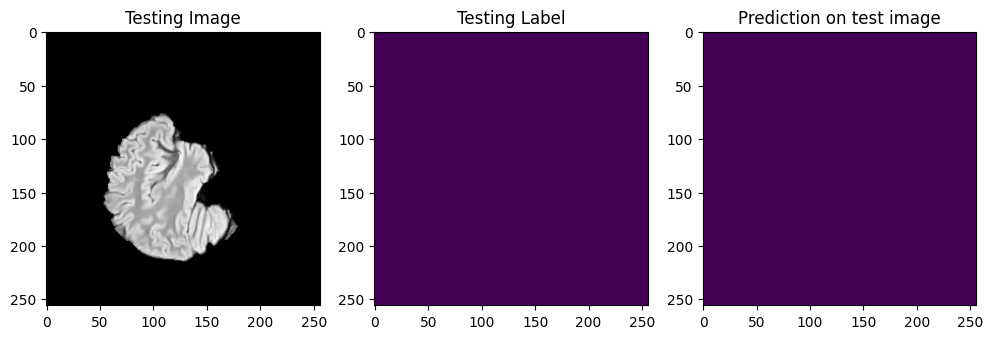

In [ ]:


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

############################################################